<a href="https://colab.research.google.com/github/Nomade25/Mackenzie/blob/main/MLP_com_Keras_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mlp
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings ("ignore")

 
import matplotlib.pyplot as graph
%matplotlib inline
graph.rcParams['figure.figsize'] = (15,5)
graph.rcParams["font.family"] = 'DejaVu Sans'
graph.rcParams["font.size"] = '12'
graph.rcParams['image.cmap'] = 'rainbow'
 
 
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


## MLP COM Keras

import tensorflow as tf
import keras
print('keras using %s backend'%keras.backend.backend())


keras using tensorflow backend


In [ ]:
# Carregando dataset
dataset_titanic = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Arquivos/train_titanic.csv") 

In [ ]:
dataset_titanic.head()
# Temos:
# Id do Passageiro
# SObreviventes (varivavel dependente)
# Pclass (classe do passageiro)
# Name, Sex, Age
# SibSP  relação familiar: sibsp (sobrinho, sobrinha, irmãos e meios irmão) | Spouse (marido e esposa)
# Parch relação familiar: parent(mãe e pai) | Child (filho ou filha e enteados)
# Ticket (nº do ticket)
# fare tarifa do passageiro
# Cabin nº da cabine
# Embarked porto que o passageiro embarcou

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# quais as colunas com valores vazios ou nulos?

(dataset_titanic.isnull().sum()).sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [ ]:
# Descobrindo a idade média

idadeMedia = dataset_titanic['Age'].mean()
idadeMedia

29.69911764705882

In [ ]:
# Vamos arredondar a idade pois não interessa valores decimais

idadeMedia = math.floor(idadeMedia)

In [ ]:
# Dando um update nos valores de idade nula para a média dos passgeiros

dataset_titanic.update(dataset_titanic['Age'].fillna(idadeMedia))

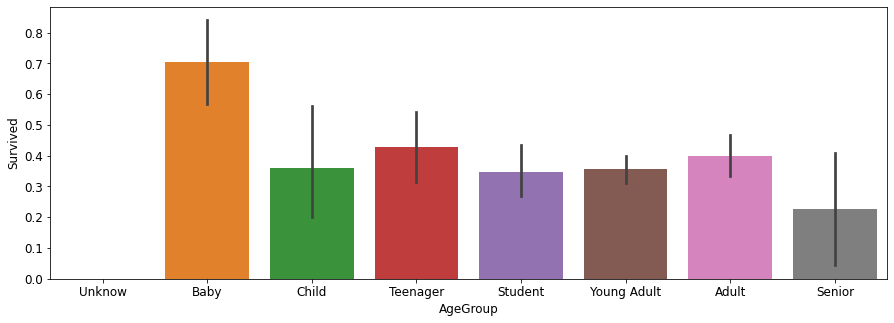

In [ ]:
# vamos usar um processo de bins para montar uma categorias de idade  a partir da feature Age tratada
# e criar assim sobreviventes por faixa etária
bins= [-1,0,5,12,18,24,35,60, np.inf]
labels= ['Unknow','Baby', 'Child', 'Teenager', 'Student', 'Young Adult','Adult', 'Senior']
dataset_titanic['AgeGroup'] = pd.cut(dataset_titanic["Age"], bins, labels =labels)
sns.barplot(x="AgeGroup",y="Survived", data= dataset_titanic)
plt.show()

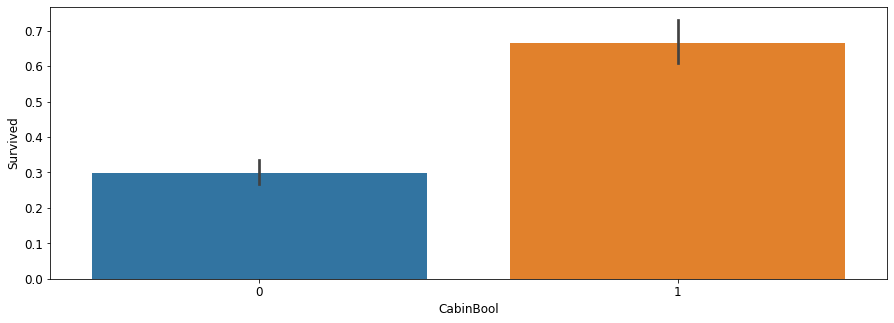

In [ ]:
# Como cabine tem poucos preenchimentos tranformando em bit 0 ou 1

dataset_titanic["CabinBool"]= (dataset_titanic["Cabin"].notnull().astype('int'))

sns.barplot(x='CabinBool', y= 'Survived', data= dataset_titanic)

In [ ]:
# Vmos pegar esses 2 passegeiros que o embarque esta nulo e preencher com algum valor mais constante
dataset_titanic = dataset_titanic.fillna({"Embarked": "S"})

In [ ]:
# Agora mapeando esses valores para númerico
Embarked ={"S":1,"C":2,"Q":3}
dataset_titanic['Embarked'] = dataset_titanic['Embarked'].map(Embarked)

In [ ]:
# Vamos mudar os dados categoricos de sexo para numerico
sex_mapa = {"male":0, "female":1}
dataset_titanic['Sex'] = dataset_titanic['Sex'].map(sex_mapa)
dataset_titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup,CabinBool
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,1,Student,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,2,Adult,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,Young Adult,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,1,Young Adult,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,1,Young Adult,0


In [ ]:
# Podemos pegar a feature nome do passageiro e criar alguma feateure a partir do nome de tramento
# Criando uma nova feature a partir do titulo (nome de tratamento)
dataset_titanic ['Titulo'] = dataset_titanic['Name'].str.extract('([A-Za-z]+)\.',expand=False) 

In [ ]:
pd.crosstab(dataset_titanic['Titulo'],dataset_titanic['Sex'])
# Abaixo o count por titulo com sexo

Sex,0,1
Titulo,,
Capt,1,0
Col,2,0
Countess,0,1
Don,1,0
Dr,6,1
Jonkheer,1,0
Lady,0,1
Major,2,0
Master,40,0


In [ ]:
 #Podemos resumir os títulos por tratamentos mais comuns
 
dataset_titanic['Titulo'] = dataset_titanic['Titulo'].replace(['Lady','Capt','Col','Don','Dr','Major','Rev','Jonkheer','Dona'],'Rare') 
dataset_titanic['Titulo'] = dataset_titanic['Titulo'].replace(['Countess','Lady','Sir'],'Royal')
dataset_titanic['Titulo'] = dataset_titanic['Titulo'].replace('Mlle','Miss')
dataset_titanic['Titulo'] = dataset_titanic['Titulo'].replace('Ms','Miss')
dataset_titanic['Titulo'] = dataset_titanic['Titulo'].replace('Mme','Mrs')

In [ ]:
dataset_titanic[['Titulo','Survived']].groupby(['Titulo'], as_index=False).mean()

,Titulo,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.285714
5,Royal,1.000000


In [ ]:
# Transformar titulo em numerico
Titulo = {"Mr":1,"Miss":2, "Mrs":3, "Master":4, "Royal":5, "Rare":6}
dataset_titanic['Titulo']= dataset_titanic['Titulo'].map(Titulo)
dataset_titanic['Titulo'] = dataset_titanic['Titulo'].fillna(0)

In [ ]:
# transformar AgeGroup para numerico

AgeGroup = {"Unknow":0,"Baby":1, "Child":2, "Teenager":3, "Student":4, "Young Adult":5,"Adult":6, "Senior":7}
dataset_titanic['AgeGroup']= dataset_titanic['AgeGroup'].map(AgeGroup)

In [ ]:
# Como está a questão dos nulos agora
(dataset_titanic.isnull().sum()).sort_values(ascending=False)

Cabin          687
Titulo           0
CabinBool        0
AgeGroup         0
Embarked         0
Fare             0
Ticket           0
Parch            0
SibSp            0
Age              0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [ ]:
# Eliminando features com pouco relevancia e "Cabin" pois extraimos o boleano dela
dataset_titanic = dataset_titanic.drop(['Name', 'PassengerId','Cabin','Ticket'], axis =1)

In [ ]:
# tranformar atributos para númerico
dataset_titanic['AgeGroup'] = dataset_titanic['AgeGroup'].astype('int64')
dataset_titanic['Age'] = dataset_titanic['Age'].astype('int64')
dataset_titanic['Fare'] = dataset_titanic['Fare'].astype('int64')

In [ ]:
dataset_titanic.dtypes

# Legal

Survived     int64
Pclass       int64
Sex          int64
Age          int64
SibSp        int64
Parch        int64
Fare         int64
Embarked     int64
AgeGroup     int64
CabinBool    int64
Titulo       int64
dtype: object

In [ ]:
dataset_titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Titulo
0,0,3,0,22,1,0,7,1,4,0,1
1,1,1,1,38,1,0,71,2,6,1,3
2,1,3,1,26,0,0,7,1,5,0,2
3,1,1,1,35,1,0,53,1,5,1,3
4,0,3,0,35,0,0,8,1,5,0,1


Após a trativa vamos criar a MLP daqui:


In [ ]:
# Criando um novo dataset com algumas caracteristicas apenas
dataset_titanic_MLP = dataset_titanic.drop(['SibSp','Parch','Fare','Age','CabinBool'], axis =1)


In [ ]:
dataset_titanic_MLP.head()

,Survived,Pclass,Sex,Embarked,AgeGroup,Titulo
0,0,3,0,1,4,1
1,1,1,1,2,6,3
2,1,3,1,1,5,2
3,1,1,1,1,5,3
4,0,3,0,1,5,1


In [ ]:
print("Shape of data set:", dataset_titanic_MLP.shape)

Shape of data set: (891, 6)


In [ ]:
# temos 891 passageiros com 6 caracteristica (Sobrevivente, Classe, LocalEmbarque, Grupo e Titilo)
# removendo a variavel objetiva do dataset
# Defines the feature dataframe
df_titanic_MLP = dataset_titanic_MLP.drop(['Survived'], axis = 1)

Nossa label temos 2 tipo de passageiro o que sobreviveu 1 e o que não sobreviveu 0

Vamos representar como:

Não Sobreviveu = 0.1

Sobreviveu = 1.0

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# This sets the  labels (numerical)
labels = np.array(dataset_titanic_MLP['Survived'])

###
# REPLACE THE <addLabels> BELOW WITH labels
###
onehot = OneHotEncoder(sparse = False).fit_transform(np.transpose([labels]))

In [ ]:
print(onehot[:10])

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [ ]:
# vamos criar o modelo de teste e treino?
# vamos trabalhar com a proporção 60% treino e 40% teste do dataframe


train_X = df_titanic_MLP.values[:535]
train_Y = onehot[:535]

test_X = df_titanic_MLP.values[356:]
test_Y = onehot[356:]

In [ ]:
# Vamos carregar agora o modelo para estrutura do Keras

# Set a randomisation seed for replicatability.
np.random.seed(6)


# This creates our base model for us to add to
###
# REPLACE THE <addSequential> BELOW WITH Sequential()
###
model = keras.models.Sequential()

# Montando a estrutura com a quantidade exata de camadas

# 5 entradas
# 15 para layer 1
# 5 para layer 2
# e 2 saídas (sobrevivente ou não)

structure = [5, 15, 5, 2]



# Input layer + hidden layer 1
model.add(keras.layers.Dense(units=structure[1], input_dim = structure[0], activation = 'tanh'))

# Hidden layer 2
model.add(keras.layers.Dense(units=structure[2], activation = 'tanh'))

# Output layer - note that the activation function is softmax
# Softmax will predict a category and provide a value for how likely this is the correct prediction.
model.add(keras.layers.Dense(units=structure[3], activation = tf.nn.softmax))

print("Layer structure:", structure)

Layer structure: [5, 15, 5, 2]


Vamos rodar o teste !

In [ ]:
# Let's compile the model

###
# REPLACE THE <addLoss> WITH 'categorical_crossentropy', <addOptimizer> WITH 'sgd', AND <addMetric> with 'accuracy' (INCLUDING THE QUOTES)
###
model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])
###

# Time to fit the model
print('Starting training')

###
# REPLACE THE <addTrainX> WITH train_X AND <addTrainY> WITH train_Y
###
training_stats = model.fit(train_X, train_Y, batch_size = 1, epochs = 24, verbose = 0)
###

print('Training finished')
print('Training Evaluation: loss = %0.3f, accuracy = %0.2f%%'
      %(training_stats.history['loss'][-1], 100 * training_stats.history['accuracy'][-1]))

Starting training
Training finished
Training Evaluation: loss = 0.417, accuracy = 83.93%


In [ ]:
Melhor resultado encontrado foi esse com 24 epochs

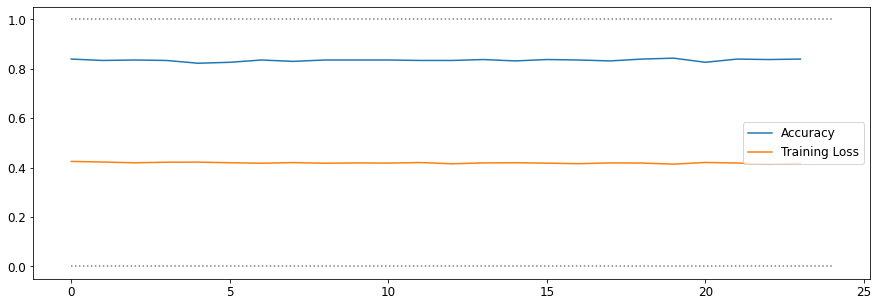

In [ ]:

accuracy, = graph.plot(training_stats.history['accuracy'],label = 'Accuracy')
training_loss, = graph.plot(training_stats.history['loss'],label = 'Training Loss')


graph.legend(handles = [accuracy,training_loss])
loss = np.array(training_stats.history['loss'])
xp = np.linspace(0, loss.shape[0], 10 * loss.shape[0])
graph.plot(xp, np.full(xp.shape, 1), c = 'k', linestyle = ':', alpha = 0.5)
graph.plot(xp, np.full(xp.shape, 0), c = 'k', linestyle = ':', alpha = 0.5)
graph.show()

Vamos rodar a base de teste

In [ ]:
###
# REPLACE <addTestX> WITH test_X AND <addTestY> with test_Y
###
evaluation = model.evaluate(test_X, test_Y, verbose=0)
###

print('Test Set Evaluation: loss = %0.6f, accuracy = %0.2f' %(evaluation[0], 100*evaluation[1]))

Test Set Evaluation: loss = 0.420789, accuracy = 81.68


Ficou um desvio de quase 3 pontos percentuais do treino para este exemplo, tentei rodar utilizando outras camadas, entretanto não houve uma melhora 
espressiva no resultado. Talvez a ideia de mexer nas features seria uma saída.

                                #### FIM #####











